# Simple Spotify Songs Recommendation
### Leo Zhang

## 0. Introduce
For the upcoming summer season, I decided to create a new playlist named "Sunset Vibe". I've manually curated 15 songs to begin this playlist. The goal is to analyze the features of these initial 15 songs and use the insights to generate recommendations from a broad songs pool that spans from "Best Indie 2010" to "Best Indie 2022". This would help in expanding the playlist while ensuring that the new additions align with the vibe of the original songs. Let's dive into the process.

## 1. Setup
### 1.1 Import libraries

In [2]:
# Import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

### 1.2 Set Spotify API and fetch my playlist

In [3]:
# Set up Spotify API client (Erase keys for public version)
client_id = '0022c43674424d66816e1fb071899dab'
client_secret = '20ec9ac44d4b409593d0df6ed6fdccbb'

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Fetch tracks from "Sunset Vibe" playlist
playlist_id = '2bWvMWFVAHtDZonSeFVsPg'
results = sp.playlist(playlist_id)
tracks = results['tracks']['items']
while results['tracks']['next']:
    results = sp.next(results['tracks'])
    tracks.extend(results['tracks']['items'])

# Create a dataframe to show the result
track_names = []
artist_names = []

for track in tracks:
    track_names.append(track['track']['name'])
    artist_names.append(', '.join([artist['name'] for artist in track['track']['artists']]))

df_tracks = pd.DataFrame({
    'Track Name': track_names,
    'Artist Name': artist_names
})

print(df_tracks)


                  Track Name                    Artist Name
0              Best Disaster                           Cuco
1                 In My Room                    Chance Peña
2           The One You Love                     Glenn Frey
3                golden hour                           JVKE
4             Nobody Gets Me                            SZA
5                   Midnight  Toby Sebastian, Florence Pugh
6               Blue Spirits                         DWLLRS
7                   Kingston                   Faye Webster
8                       Ride                           HYBS
9              Teenage Dream                  Stephen Dawes
10  SLOW DANCING IN THE DARK                           Joji
11           Out Of The Blue                   Katie Pruitt
12                        愛是              Schoolgirl Byebye
13                    august                   Taylor Swift
14               Only Friend                        Wallows


## 2. EDA (Exploratory Data Analysis)
### 2.1 Fetch song features

In [4]:
# Get the track IDs
track_ids = [track['track']['id'] for track in tracks]

# Get the audio features for the tracks
audio_features = []
for track_id in track_ids:
    features = sp.audio_features([track_id])[0]
    audio_features.append(features)

# Create a dateframe from the audio features
df = pd.DataFrame(audio_features)
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.533,0.847,8,-7.261,1,0.0383,0.012700,0.533000,0.1590,0.4940,140.088,audio_features,6dmZu0IVmbT1rDIiYiRchg,spotify:track:6dmZu0IVmbT1rDIiYiRchg,https://api.spotify.com/v1/tracks/6dmZu0IVmbT1...,https://api.spotify.com/v1/audio-analysis/6dmZ...,173262,4
1,0.408,0.338,4,-13.626,1,0.0431,0.521000,0.000639,0.0732,0.1000,133.943,audio_features,7CiDwKE62N6ey3LyG6s7xc,spotify:track:7CiDwKE62N6ey3LyG6s7xc,https://api.spotify.com/v1/tracks/7CiDwKE62N6e...,https://api.spotify.com/v1/audio-analysis/7CiD...,177609,3
2,0.603,0.302,7,-13.698,1,0.0242,0.440000,0.007010,0.1720,0.4880,75.274,audio_features,4uvARnZIajUDXWXPifhK3B,spotify:track:4uvARnZIajUDXWXPifhK3B,https://api.spotify.com/v1/tracks/4uvARnZIajUD...,https://api.spotify.com/v1/audio-analysis/4uvA...,274560,4
3,0.515,0.593,4,-4.801,1,0.0322,0.653000,0.162000,0.2500,0.1530,94.467,audio_features,4yNk9iz9WVJikRFle3XEvn,spotify:track:4yNk9iz9WVJikRFle3XEvn,https://api.spotify.com/v1/tracks/4yNk9iz9WVJi...,https://api.spotify.com/v1/audio-analysis/4yNk...,209260,3
4,0.358,0.284,7,-8.285,1,0.0285,0.805000,0.000000,0.1830,0.2760,99.796,audio_features,5Y35SjAfXjjG0sFQ3KOxmm,spotify:track:5Y35SjAfXjjG0sFQ3KOxmm,https://api.spotify.com/v1/tracks/5Y35SjAfXjjG...,https://api.spotify.com/v1/audio-analysis/5Y35...,180853,3
5,0.732,0.406,4,-7.330,1,0.0343,0.583000,0.000023,0.0880,0.5840,117.903,audio_features,4gqnJeeFu2GbOnHawPjWHn,spotify:track:4gqnJeeFu2GbOnHawPjWHn,https://api.spotify.com/v1/tracks/4gqnJeeFu2Gb...,https://api.spotify.com/v1/audio-analysis/4gqn...,285077,4
6,0.657,0.657,9,-5.707,1,0.0478,0.640000,0.000000,0.2870,0.3750,130.002,audio_features,4Z3Mmn6cIeuKprHQyyAbXQ,spotify:track:4Z3Mmn6cIeuKprHQyyAbXQ,https://api.spotify.com/v1/tracks/4Z3Mmn6cIeuK...,https://api.spotify.com/v1/audio-analysis/4Z3M...,188308,4
7,0.730,0.355,10,-9.130,0,0.0359,0.154000,0.001550,0.1170,0.5600,142.143,audio_features,5WbfFTuIldjL9x7W6y5l7R,spotify:track:5WbfFTuIldjL9x7W6y5l7R,https://api.spotify.com/v1/tracks/5WbfFTuIldjL...,https://api.spotify.com/v1/audio-analysis/5Wbf...,202653,4
8,0.757,0.393,5,-7.942,1,0.2120,0.788000,0.000986,0.0501,0.7150,77.985,audio_features,37HhnXqIRFSSJXWsysl6B7,spotify:track:37HhnXqIRFSSJXWsysl6B7,https://api.spotify.com/v1/tracks/37HhnXqIRFSS...,https://api.spotify.com/v1/audio-analysis/37Hh...,181623,4
9,0.622,0.375,10,-9.069,1,0.0279,0.411000,0.000000,0.0812,0.2210,111.968,audio_features,3GWaFFi6TlPcZLYmCCHZ9O,spotify:track:3GWaFFi6TlPcZLYmCCHZ9O,https://api.spotify.com/v1/tracks/3GWaFFi6TlPc...,https://api.spotify.com/v1/audio-analysis/3GWa...,178000,4


### 2.2 Visualize Distributions and Outliers with Box Plots

To get a better understanding of the distribution of the song features, I created a grid of box plots. Each box plot will represent one feature, showing its median (the line in the box), interquartile range (the box), and potential outliers (the dots beyond the whiskers).

Outliers are observations that are significantly different from the others. They can be caused by variability in the data or errors. In the case, outliers may represent songs that are stylistically different from the rest. 


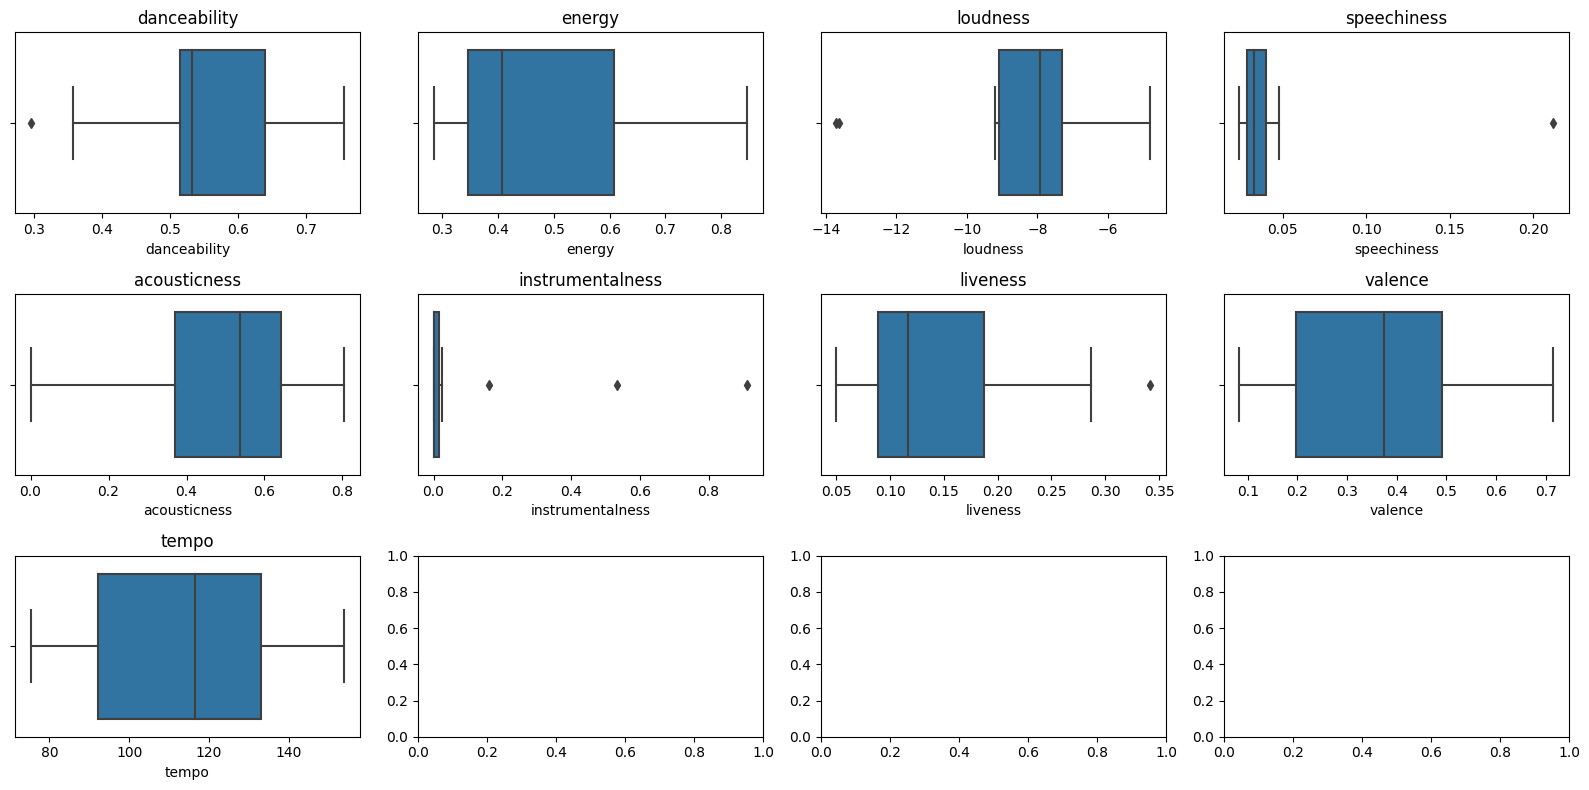

In [5]:
# Create box plots to find outliers
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence' , 'tempo']

# Set the number of rows and columns for the grid
n_rows = 3
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))

for i, feature in enumerate(features):
    row = i // n_cols
    col = i % n_cols
    
    sns.boxplot(x=df[feature], ax=axes[row, col])
    axes[row, col].set_title(feature)

plt.tight_layout()
plt.show()


According to the figure, I have identified several outliers and have decided to exclude songs 1, 2, 8, and 14 from the dataset.

Additionally, based on the box plot analysis, I have observed that the "instrumentalness" feature exhibits extremely short whiskers and numerous outliers.

Moving forward, I am going to exclude song 1, 2, 8 and 14 and the feature "instrumentalness".


In [6]:
df_clean = df.drop([1, 2, 8, 14])
df_clean = df_clean.reset_index(drop=True)
df_clean

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.533,0.847,8,-7.261,1,0.0383,0.0127,0.533000,0.1590,0.494,140.088,audio_features,6dmZu0IVmbT1rDIiYiRchg,spotify:track:6dmZu0IVmbT1rDIiYiRchg,https://api.spotify.com/v1/tracks/6dmZu0IVmbT1...,https://api.spotify.com/v1/audio-analysis/6dmZ...,173262,4
1,0.515,0.593,4,-4.801,1,0.0322,0.6530,0.162000,0.2500,0.153,94.467,audio_features,4yNk9iz9WVJikRFle3XEvn,spotify:track:4yNk9iz9WVJikRFle3XEvn,https://api.spotify.com/v1/tracks/4yNk9iz9WVJi...,https://api.spotify.com/v1/audio-analysis/4yNk...,209260,3
2,0.358,0.284,7,-8.285,1,0.0285,0.8050,0.000000,0.1830,0.276,99.796,audio_features,5Y35SjAfXjjG0sFQ3KOxmm,spotify:track:5Y35SjAfXjjG0sFQ3KOxmm,https://api.spotify.com/v1/tracks/5Y35SjAfXjjG...,https://api.spotify.com/v1/audio-analysis/5Y35...,180853,3
3,0.732,0.406,4,-7.330,1,0.0343,0.5830,0.000023,0.0880,0.584,117.903,audio_features,4gqnJeeFu2GbOnHawPjWHn,spotify:track:4gqnJeeFu2GbOnHawPjWHn,https://api.spotify.com/v1/tracks/4gqnJeeFu2Gb...,https://api.spotify.com/v1/audio-analysis/4gqn...,285077,4
4,0.657,0.657,9,-5.707,1,0.0478,0.6400,0.000000,0.2870,0.375,130.002,audio_features,4Z3Mmn6cIeuKprHQyyAbXQ,spotify:track:4Z3Mmn6cIeuKprHQyyAbXQ,https://api.spotify.com/v1/tracks/4Z3Mmn6cIeuK...,https://api.spotify.com/v1/audio-analysis/4Z3M...,188308,4
5,0.730,0.355,10,-9.130,0,0.0359,0.1540,0.001550,0.1170,0.560,142.143,audio_features,5WbfFTuIldjL9x7W6y5l7R,spotify:track:5WbfFTuIldjL9x7W6y5l7R,https://api.spotify.com/v1/tracks/5WbfFTuIldjL...,https://api.spotify.com/v1/audio-analysis/5Wbf...,202653,4
6,0.622,0.375,10,-9.069,1,0.0279,0.4110,0.000000,0.0812,0.221,111.968,audio_features,3GWaFFi6TlPcZLYmCCHZ9O,spotify:track:3GWaFFi6TlPcZLYmCCHZ9O,https://api.spotify.com/v1/tracks/3GWaFFi6TlPc...,https://api.spotify.com/v1/audio-analysis/3GWa...,178000,4
7,0.515,0.479,3,-7.458,1,0.0261,0.5440,0.005980,0.1910,0.284,88.964,audio_features,0rKtyWc8bvkriBthvHKY8d,spotify:track:0rKtyWc8bvkriBthvHKY8d,https://api.spotify.com/v1/tracks/0rKtyWc8bvkr...,https://api.spotify.com/v1/audio-analysis/0rKt...,209274,4
8,0.515,0.311,6,-7.743,1,0.0287,0.3280,0.000153,0.1110,0.172,116.575,audio_features,3aV4xJGmhJHnyRhnzx5iHE,spotify:track:3aV4xJGmhJHnyRhnzx5iHE,https://api.spotify.com/v1/tracks/3aV4xJGmhJHn...,https://api.spotify.com/v1/audio-analysis/3aV4...,312613,3
9,0.588,0.422,2,-8.838,1,0.0296,0.6430,0.024900,0.0903,0.392,132.063,audio_features,4iupwr2vDSxgxOWvGLk3sj,spotify:track:4iupwr2vDSxgxOWvGLk3sj,https://api.spotify.com/v1/tracks/4iupwr2vDSxg...,https://api.spotify.com/v1/audio-analysis/4iup...,246913,3


## 3. Recommendation tracks pool
Using the Spotify API's search functionality to fetch a collection of songs that span from "Best Indie 2010" to "Best Indie 2022".


In [7]:
def fetch_tracks_from_playlists(playlist_ids):
    track_list = []
    for playlist_id in playlist_ids:
        offset = 0
        while True:
            response = sp.playlist_items(playlist_id,
                                         offset=offset,
                                         fields='items.track.id,total',
                                         additional_types=['track'])
            
            if len(response['items']) == 0:
                break
            
            track_list += [item['track']['id'] for item in response['items']]
            offset = offset + len(response['items'])
            print(offset, "/", response['total'])

    return track_list

In [8]:
playlist_ids = ['37i9dQZF1DWULq23fLWDsl', '37i9dQZF1DX2Vedp1NjGn9', '37i9dQZF1DX3n9iLlurL09', '37i9dQZF1DWW2mn5wEfG6q', '37i9dQZF1DX3asLxmR3A9e',
                '37i9dQZF1DX6B9HH2fw0SO', '37i9dQZF1DX0XnW5YpwS0o', '37i9dQZF1DXcR9zJKQUPAH', '37i9dQZF1DWY7UuaejrQg4', '37i9dQZF1DX05We5FN3NiD',
                '37i9dQZF1DWWkGXMGv9j4M', '37i9dQZF1DWW06b4n9Ho9J', '37i9dQZF1DX0lyZ45Ayi9S']

Get pool tracks' features

In [9]:
track_list = fetch_tracks_from_playlists(playlist_ids)

# fetch audio features for these tracks
tracks_features_list = []
for i in range(0,len(track_list),50):
    audio_features = sp.audio_features(track_list[i:i+50])
    for track in audio_features:
        tracks_features_list.append(track)

df_recommendation_pool = pd.DataFrame(tracks_features_list)

100 / 100
100 / 100
100 / 100
100 / 100
100 / 100
100 / 100
100 / 100
100 / 100
100 / 100
100 / 100
100 / 100
100 / 104
104 / 104
75 / 75


## 4. Calculate Similarity
Use cosine similarity to find songs that have similar features to the songs in the existing playlist.

In the normalization step, I use the MinMaxScaler to scale the features of the playlist tracks and the recommendation pool tracks, ensuring all features are on the same scale for similarity computation.

Next, compute the cosine similarity between each track in the playlist and the recommendation pool, quantifying the similarity between the feature vectors.

Using the average cosine similarity, I select the top 50 tracks with the highest average similarity as the recommended tracks

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

# define the features
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'liveness', 'valence' , 'tempo']

# normalize the features existing playlist tracks
scaler = MinMaxScaler()
df_playlist_scaled = df.copy()
df_playlist_scaled[features] = scaler.fit_transform(df[features])

# normalize the features of the recommendation pool tracks
df_recommendation_pool_scaled = df_recommendation_pool.copy()
df_recommendation_pool_scaled[features] = scaler.transform(df_recommendation_pool[features])

# compute the cosine similarity between original playlist tracks and recommendation pool tracks
cosine_sim = cosine_similarity(df_playlist_scaled[features], df_recommendation_pool_scaled[features])

# get the average cosine similarity for each song in the recommendation pool
average_cosine_sim = cosine_sim.mean(axis=0)

# get the top 50 songs
top_50_indices = average_cosine_sim.argsort()[-50:][::-1]
top_50_tracks = df_recommendation_pool.iloc[top_50_indices]

track_rec_names = []
artist_rec_names = []

for id in top_50_tracks['id']:
    track = sp.track(id)
    track_rec_names.append(track['name'])
    artist_rec_names.append(', '.join([artist['name'] for artist in track['artists']]))

# Create a dataframe to store the track and artist names
df_recommendations = pd.DataFrame({'Track Name': track_rec_names,'Artist Name': artist_rec_names})

# Display the dataframe by top 20
df_recommendations


,Track Name,Artist Name
0,Face to Face,Rex Orange County
1,Morning,Beck
2,Elephant,Tame Impala
3,Landfill,Daughter
4,Doom Days,Bastille
5,Afterglow,Luna Li
6,Multi-Love,Unknown Mortal Orchestra
7,Angela,The Lumineers
8,prom dress,mxmtoon
9,Take Me to Church,Hozier


## 5. Create a new playlist to my spotify

In [11]:
# Define the scope of the permissions
scope = 'playlist-modify-public'

username = 'drizzle'

token = spotipy.util.prompt_for_user_token(username, scope, client_id='0022c43674424d66816e1fb071899dab', 
                                           client_secret='20ec9ac44d4b409593d0df6ed6fdccbb', 
                                           redirect_uri='http://localhost:3000')

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)


In [12]:
playlist_name = "Sunset Recommendations"
new_playlist = sp.user_playlist_create(user='NP8Fig7L4x400DfQ4YSPL07D7', name=playlist_name, public=True)

new_playlist_id = new_playlist['id']

track_ids = top_50_tracks['id'].tolist()
sp.user_playlist_add_tracks(user='NP8Fig7L4x400DfQ4YSPL07D7', playlist_id=new_playlist_id, tracks=track_ids)

{'snapshot_id': 'MiwzMDIxOTQ1YmNhODA4OTA0YjQ3MjI4YzJlYjFhYjcyZTVhNTE5NmI0'}

## Done!
Feel free to check out the playlist: https://open.spotify.com/playlist/4pqJcbTCEv4i8p0M5YmUdo?si=9d3e366ad53f4d58


![Sunset recommendations](../../images/spotify.png)